## 1.   Config environment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/Othercomputers/PC/msc_final_project/TPU/attack/whitebox/R_FSGM')

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

# cifar10
from tensorflow.keras import datasets, layers, models

import matplotlib.pyplot as plt
import numpy as np
import time

In [4]:
# Recreate the exact same model, including its weights and the optimizer
#model = tf.keras.models.load_model('..\..\..\build\saved_model\Simple_CNN\HDF5\Simple_CN.h5', compile=True)
model = tf.keras.models.load_model('../../../build/saved_model/ResNet_TransferLearning/HDF5/ResNet_TransferLearning.h5', compile=True)

# Show the model architecture
#model.summary()



In [5]:
# Utility functions
def print_shapes(train_images, test_images, train_labels, test_labels):
  print(f"train_images: {train_images.shape}\n"\
      f"test_images: {test_images.shape}\n"\
      f"train_labels: {train_labels.shape}\n"\
      f"test_labels: {test_labels.shape}\n")

In [6]:
# Load the image
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

170508288/170498071 [==============================] - 2s 0us/step


In [7]:
# Preprocessing images and labels
height, width, channels = 32, 32, 3
nb_classes = 10 
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog',
               'horse', 'ship', 'truck']


train_images = train_images.reshape((-1, height, width, channels))
test_images = test_images.reshape((-1, height, width, channels))

train_labels = tf.keras.utils.to_categorical(train_labels, nb_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, nb_classes)

print_shapes(train_images, test_images, train_labels, test_labels)

train_images: (50000, 32, 32, 3)
test_images: (10000, 32, 32, 3)
train_labels: (50000, 10)
test_labels: (10000, 10)



## 2. Create R_FSGM Function

In [8]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def R_FSGM(input_image, input_image_label, epsilon, alpha, Parameters_I):
    '''Create the adversarial example using the R_FSGM attack

    Formula:
        x_adv = x' + (epsilon - alpha) * sign(grad(x', Ytrue)), where x' = x + alpha * sample(N(0**d, I**d))

    Args:
        input_image(numpy.ndarray): the original image, shape (32, 32, 3)
        input_image_label(numpy.ndarray): the original label, shape (10, )
        epsilon(float): the maximum perturbation
        alpha(float): the step size
        Parameters_I(int): the parameters of the attack
    
    Returns:
        input_image_adv(tonser): the adversarial example, shape (32, 32, 3)

    '''



    input_image = tf.cast(input_image, tf.float32)
    sample_from_Gaussian = tf.get_static_value(tfp.distributions.Normal(loc=0., scale=Parameters_I**2).sample(1)[0])
    input_image = input_image + alpha * (sample_from_Gaussian/255)

    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(tf.reshape(input_image, [1, 32, 32, 3]))[0]
        loss = loss_object(tf.cast(input_image_label, tf.float32), prediction)
    gradient = tape.gradient(loss, input_image)
    sign_grad = tf.sign(gradient)

    input_image = input_image + (epsilon - alpha) * sign_grad

    input_image = tf.clip_by_value(input_image, 0, 1)

    return input_image

## 3. Test Function and select different parameters

### 3.1 test a simple image

Prediction from CNN: frog


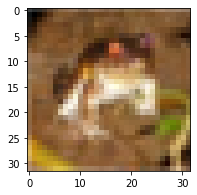

In [ ]:
# Selecting random image for testing
rand_idx = 0
image = train_images[rand_idx].reshape((1, height, width, channels))
label = train_labels[rand_idx]

print(f'Prediction from CNN: {label_names[np.where(label==1)[0][0]]}')
plt.figure(figsize=(3,3))
plt.imshow(image.reshape((height, width, channels)))
plt.show()

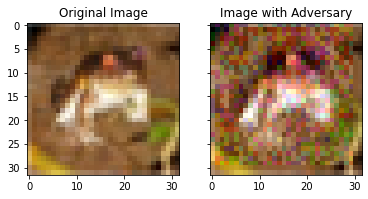

In [ ]:
# Comparing both images 
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image.reshape(height,width, channels))
ax1.set_title("Original Image")
ax2.imshow(R_FSGM)
ax2.set_title("Image with Adversary")
plt.show()

In [ ]:
# Comparing predictions
print(f'Normal Image Prediction: {label_names[model.predict(image).argmax()]}')
print(f"Adversary Prediction: {label_names[model.predict(tf.reshape(R_FSGM(train_images[0], train_labels[0], 0.2, 0.1, 1), [1, 32, 32, 3])).argmax()]}")

1/1 [==============================] - 0s 28ms/step
Normal Image Prediction: frog
1/1 [==============================] - 0s 21ms/step
Adversary Prediction: cat


### 3.2 try different parameters and see different

In [ ]:
epsilons = [1, 2, 4, 8, 16, 32]
epsilons = np.asarray(epsilons)
epsilons = np.divide(epsilons, 255)

In [ ]:

def display_images(image, image_label, image_labels, epsilons, model):
  '''Displays images with adversarial noise
  Args:
    image(np.array):  input image, shape like (height, width, channels)
    image_label(numpy.ndarray): label of the image, shape like (nb_classes, )
      array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)
    image_labels(list): list of labels of the images, shape like (nb_classes, )
    epsilons(list): list of epsilon parameters for I-FSGM
    model(tf.keras.Model): model to be used for adversarial attack

  Examples:
      >>> display_images(train_images[0], train_labels[0], label_names, [0.1, 0.2, 0.3], [1, 3, 5], model)

  '''

  fig, axs = plt.subplots(len(epsilons), figsize=(20, 20))

  for i in range(len(epsilons)):

    alpha = epsilons[i] / 2

    adv_image = R_FSGM(image, image_label, epsilons[i], alpha, 1)
    axs[i].imshow(adv_image)
    axs[i].set_title(f'alpha: {round(alpha, 5)}, epsilon: {round(epsilons[i], 5)}, {image_labels[model(tf.reshape(image, [1, 32, 32, 3])).numpy().argmax()]}', fontsize=10)
    axs[i].axis('off')


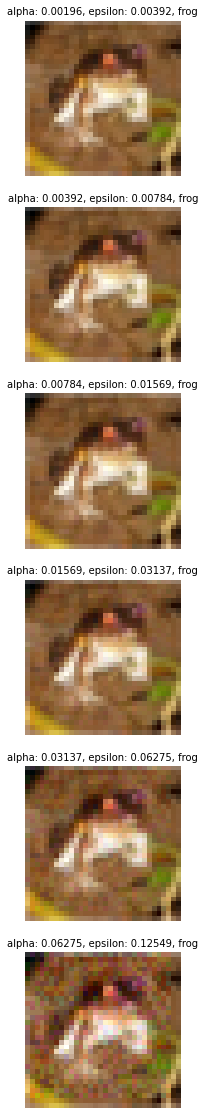

In [ ]:
display_images(train_images[0], train_labels[0], label_names, epsilons, model)

## 4    create a adversary noise set and test the model right rate

In [9]:
def create_input_set(image_set, label_set, epsilon, alpha, Parameters_I):
    '''Creates input set for map function
    Args:
        image_set(np.array): input image, shape like (nb_images, height, width, channels)
        label_set(np.array): input label, shape like (nb_images, nb_classes)
        epsilon(float): 
        alpha(float): 
        Parameters_I(int):

    Examples:
        >>> mage_and_label_list = create_input_set(test_images, test_labels, 0.2, 0.1, 1)

    Returns:   
        mage_and_label_list(list): list of tuples, each tuple contains (image, label, epsilon, alpha, Parameters_I) 


    '''

    image_and_label_list = []

    for i in range(len(image_set)):
        image_and_label_list.append([])
        image_and_label_list[i].append(image_set[i])
        image_and_label_list[i].append(label_set[i])
        image_and_label_list[i].append(epsilon)
        image_and_label_list[i].append(alpha)
        image_and_label_list[i].append(Parameters_I)
    
    return image_and_label_list

In [10]:
#image_and_label_list = create_input_set(test_images, test_labels, 0.2, 0.1, 1)

In [11]:
def predict_and_calculate_from_original(image_and_label_list):
    global model
    global label_names

    # get the original label
    original_label = np.where(image_and_label_list[1] == 1)[0][0] 


    # use adversarial image to get the predicted label
    prediction = model(image_and_label_list[0].reshape(1, 32, 32, 3))[0]
    prediction_label = prediction.numpy().argmax()

    if prediction_label == original_label:
        final_result = 1
    else:
        final_result = 0

    return final_result

In [12]:
def predict_and_calculate_from_adv(image_and_label_list):
    global model
    global label_names

    # get the original label
    original_label = np.where(image_and_label_list[1] == 1)[0][0] 

    # get the adversarial image
    image_adv = R_FSGM(image_and_label_list[0], image_and_label_list[1], image_and_label_list[2], image_and_label_list[3], image_and_label_list[4])
    # use adversarial image to get the predicted label
    prediction = model(tf.reshape(image_adv, [1, 32, 32, 3]))[0]
    prediction_label = tf.get_static_value(tf.math.argmax(prediction))

    if prediction_label == original_label:
        final_result = 1
    else:
        final_result = 0

    return final_result

In [13]:
#list(map(predict_and_calculate_from_original, image_and_label_list[:100])).count(1)

In [14]:
#list(map(predict_and_calculate_from_adv, image_and_label_list[:1000])).count(1)

In [15]:
#result = list(map(predict_and_calculate_from_adv, image_and_label_list))

### 4.1 use test_image to test the function and calculate the accuracy

In [16]:
def get_accuracy(image_set, image_label_set, epsilon, Parameters_I):
    
    information_list = []

    total_num = len(image_set)

    start_time = time.time()

    alpha = epsilon / 2


    # calculate the accuracy of the adversarial image
    image_and_label_adv_list = create_input_set(image_set, image_label_set, epsilon, alpha, Parameters_I)

    right_num_adv = list(map(predict_and_calculate_from_adv, image_and_label_adv_list)).count(1)
    
    accuracy_adv = right_num_adv / total_num


    # calculate the accuracy of the original image
    right_num_original = list(map(predict_and_calculate_from_original, image_and_label_adv_list)).count(1)
    accuracy_original = right_num_original / total_num

    end_time = time.time()
    use_time = round(end_time - start_time, 2)

    # print the information
    print(f'epsilon: {epsilon}, alpha: {alpha}, Parameters_I: {Parameters_I}, accuracy_original: {accuracy_original}, accuracy_adv: {accuracy_adv}, use_time: {use_time}s')

    information_list.append(f'epsilon: {epsilon}, alpha: {alpha}, Parameters_I: {Parameters_I}, accuracy_original: {accuracy_original}, accuracy_adv: {accuracy_adv}, use_time: {use_time}s')

    return information_list
            

In [17]:
epsilons = [0.2, 0.4, 0.6, 0.8, 1.]
Parameters_Is = [1, 2, 3, 4, 5]

In [19]:
for i, Parameters_I in enumerate(Parameters_Is):
    for j, epsilon in enumerate(epsilons):
        information = get_accuracy(test_images, test_labels, epsilon, Parameters_I)
        

        with open('information/ResNet.txt', 'a') as f:
            f.writelines(information)
            f.write('\n')



epsilon: 0.4, alpha: 0.2, Parameters_I: 5, accuracy_original: 0.419, accuracy_adv: 0.5318, use_time: 3708.83s
epsilon: 0.6, alpha: 0.3, Parameters_I: 5, accuracy_original: 0.419, accuracy_adv: 0.4997, use_time: 3723.08s
epsilon: 0.8, alpha: 0.4, Parameters_I: 5, accuracy_original: 0.419, accuracy_adv: 0.4766, use_time: 3750.66s
epsilon: 1.0, alpha: 0.5, Parameters_I: 5, accuracy_original: 0.419, accuracy_adv: 0.4633, use_time: 3812.32s
